# Analyze decision threshold
We notice that some models always predict 1 for binary_A. We try modifiying the decision threshold and see the impact on validation metrics

In [1]:
import pathlib
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score, PrecisionRecallDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb

from src.util.definitions import PRED_DIR, DATA_ROOT
from src.util.io import read_predictions
from ghost import optimize_threshold_from_predictions

In [2]:
api = wandb.Api()
runs = api.runs("jugoetz/synferm-predictions", filters={"group": "2023-10-25-053648_780546"})

In [3]:
config_list = [run.config for run in runs]
summary_list = [run.summary._json_dict for run in runs]
name_list = [run.name for run in runs]

name_list

['2023-10-25-053648_780546_fold8',
 '2023-10-25-053648_780546_fold7',
 '2023-10-25-053648_780546_fold6',
 '2023-10-25-053648_780546_fold5',
 '2023-10-25-053648_780546_fold4',
 '2023-10-25-053648_780546_fold3',
 '2023-10-25-053648_780546_fold2',
 '2023-10-25-053648_780546_fold1',
 '2023-10-25-053648_780546_fold0']

In [4]:
preds = [read_predictions(n, "train") for n in name_list]
preds[0]

,pred_0,pred_1,pred_2
idx,,,
31920,0.794579,0.266130,0.088655
11249,0.842385,0.836633,0.346530
34717,0.832552,0.415581,0.160597
26490,0.859074,0.810026,0.517323
32534,0.866079,0.814108,0.464374
...,...,...,...
32198,0.772698,0.233655,0.068569
33167,0.782441,0.349546,0.115813
15494,0.780773,0.267427,0.105440


In [5]:
df_true = pd.read_csv(DATA_ROOT / "synferm_dataset_2023-09-05_40018records.csv")

In [6]:
comb = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds]
comb[0]

,pred_0,pred_1,pred_2,binary_A,binary_B,binary_C
31920,0.794579,0.266130,0.088655,1,0,0
11249,0.842385,0.836633,0.346530,1,1,0
34717,0.832552,0.415581,0.160597,1,1,0
26490,0.859074,0.810026,0.517323,0,1,0
32534,0.866079,0.814108,0.464374,1,1,1
...,...,...,...,...,...,...
32198,0.772698,0.233655,0.068569,0,0,0
33167,0.782441,0.349546,0.115813,1,1,0
15494,0.780773,0.267427,0.105440,0,0,0
12399,0.833367,0.805016,0.289746,1,1,0


In [7]:
bal_acc = []
f_beta = []
x = np.arange(0, 1.0001, 0.01)
y_bal_acc = np.empty((101, 9))
y_f_beta = np.empty((101, 9))
best_thresh = np.empty(9)
for fold in range(9):
    for i, threshold in enumerate(x):
        y_bal_acc[i, fold] = balanced_accuracy_score(comb[fold]["binary_A"], (comb[fold]["pred_0"] > threshold))
        y_f_beta[i, fold] = fbeta_score(comb[fold]["binary_A"], (comb[fold]["pred_0"] > threshold), beta=0.1)
    best_thresh[fold] = optimize_threshold_from_predictions(comb[fold]["binary_A"], comb[fold]["pred_0"], thresholds=x, ThOpt_metrics="Kappa") 

In [8]:
best_thresh_roc = np.empty(9)
for fold in range(9):
    best_thresh_roc[fold] = optimize_threshold_from_predictions(comb[fold]["binary_A"], comb[fold]["pred_0"], thresholds=x, ThOpt_metrics="ROC") 

In [9]:
best_thresh

array([0.75, 0.68, 0.73, 0.69, 0.7 , 0.74, 0.71, 0.7 , 0.73])

In [10]:
best_thresh_roc

array([0.81, 0.83, 0.79, 0.78, 0.77, 0.82, 0.81, 0.78, 0.81])

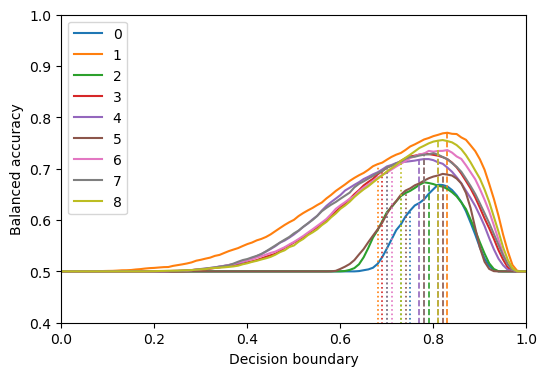

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
for fold in range(9):
    line = ax.plot(x, y_bal_acc[:, fold], label=fold)
    ax.vlines(x=best_thresh[fold], ymin=0, ymax=y_bal_acc[int((best_thresh[fold] * 100).round()), fold], ls=":", colors=line[0].get_color(), lw=1.2)
    ax.vlines(x=best_thresh_roc[fold], ymin=0, ymax=y_bal_acc[int((best_thresh_roc[fold] * 100).round()), fold], ls="--", colors=line[0].get_color(), lw=1.2)

ax.set_xlabel("Decision boundary")
ax.set_ylabel("Balanced accuracy")
ax.set_xlim(0,1)
ax.set_ylim(0.4,1)
ax.legend()

### Maximize balanced accuracy

Simple way to pick the decision threshold is to calculate the balanced accuracy over different thresholds and pick the one that maximizes it.

Note:
- Since this is average recall per class, for our problem, this heavily tilts the predictions to minimize false negatives. That also means, recall for the positive class will take a heavy hit
- Picking the maximum can be a bit unstable if the balanced_accuracy/threshold curve is not so smooth.

balanced accuracy: 0.67
recall: 0.68
precision: 0.90
f_0.5 score: 0.85

balanced accuracy: 0.77
recall: 0.74
precision: 0.95
f_0.5 score: 0.90

balanced accuracy: 0.67
recall: 0.72
precision: 0.88
f_0.5 score: 0.85

balanced accuracy: 0.73
recall: 0.74
precision: 0.91
f_0.5 score: 0.87

balanced accuracy: 0.72
recall: 0.69
precision: 0.91
f_0.5 score: 0.85

balanced accuracy: 0.69
recall: 0.66
precision: 0.91
f_0.5 score: 0.85

balanced accuracy: 0.74
recall: 0.66
precision: 0.94
f_0.5 score: 0.87

balanced accuracy: 0.73
recall: 0.67
precision: 0.92
f_0.5 score: 0.86

balanced accuracy: 0.76
recall: 0.71
precision: 0.94
f_0.5 score: 0.89



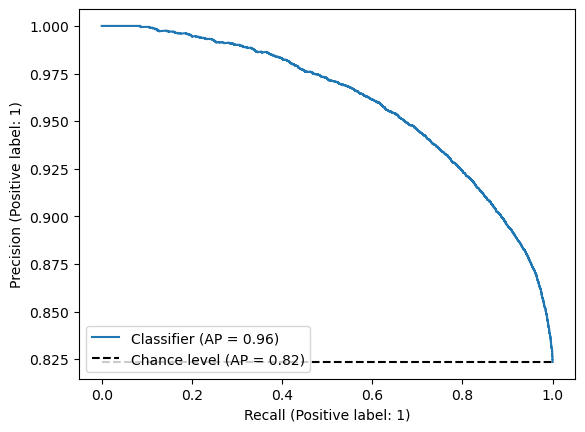

In [12]:
# try maximizing balanced accuracy on all folds
for fold in range(9):
    threshold = np.argmax(y_bal_acc[:, fold]) / 100
    y_true = comb[fold]["binary_A"]
    y_prob = comb[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    print("balanced accuracy:", f"{balanced_accuracy_score(y_true, y_pred):.2f}")
    print("recall:", f"{recall_score(y_true, y_pred):.2f}")
    print("precision:", f"{precision_score(y_true, y_pred):.2f}")
    print("f_0.5 score:", f"{fbeta_score(y_true, y_pred, beta=0.5):.2f}")
    print()

# plot the PRC
PrecisionRecallDisplay.from_predictions(y_true, y_prob, pos_label=1, drop_intermediate=True, plot_chance_level=True)

### GHOST
The Rinicker lab has published GHOST (1) for decision threshold picking.
On a high level this:
- Takes startified samples from the training set (default: without replacement)
- Determines metric (default: Cohen's kappa) for all decision thresholds
- Calculates the median metric over stratified samples for all decision thresholds
- Returns the threshold with highest median metric

(1) Esposito, C.; A. Landrum, G.; Schneider, N.; Stiefl, N.; Riniker, S. GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning. Journal of Chemical Information and Modeling 2021, 61 (6), 2623–2640. https://doi.org/10.1021/acs.jcim.1c00160.

In [13]:
# try GHOST on all folds
for i in range(9):
    threshold = best_thresh[i]
    y_true = comb[i]["binary_A"]
    y_prob = comb[i]["pred_0"]
    y_pred = (y_prob > threshold)
    print("balanced accuracy:", f"{balanced_accuracy_score(y_true, y_pred):.2f}")
    print("recall:", f"{recall_score(y_true, y_pred):.2f}")
    print("precision:", f"{precision_score(y_true, y_pred):.2f}")
    print("f_0.5 score:", f"{fbeta_score(y_true, y_pred, beta=0.5):.2f}")
    print()

balanced accuracy: 0.62
recall: 0.89
precision: 0.86
f_0.5 score: 0.87

balanced accuracy: 0.71
recall: 0.94
precision: 0.90
f_0.5 score: 0.91

balanced accuracy: 0.65
recall: 0.84
precision: 0.86
f_0.5 score: 0.85

balanced accuracy: 0.70
recall: 0.90
precision: 0.87
f_0.5 score: 0.88

balanced accuracy: 0.70
recall: 0.85
precision: 0.87
f_0.5 score: 0.87

balanced accuracy: 0.66
recall: 0.88
precision: 0.88
f_0.5 score: 0.88

balanced accuracy: 0.70
recall: 0.90
precision: 0.89
f_0.5 score: 0.89

balanced accuracy: 0.70
recall: 0.86
precision: 0.88
f_0.5 score: 0.87

balanced accuracy: 0.72
recall: 0.88
precision: 0.90
f_0.5 score: 0.90



In [14]:
# take a look at validation set metrics


In [15]:
preds_val = [read_predictions(n, "val") for n in name_list]
preds_val[0]

,pred_0,pred_1,pred_2
idx,,,
5561,0.869254,0.791833,0.382712
5570,0.844082,0.741155,0.297359
5589,0.867880,0.784376,0.397227
5603,0.863569,0.789170,0.386213
5627,0.894968,0.847806,0.491635
...,...,...,...
39363,0.840091,0.679653,0.373971
39365,0.838430,0.728873,0.406242
39384,0.874973,0.815028,0.423465


In [16]:
comb_val = [pred.merge(df_true[["binary_A", "binary_B", "binary_C"]], left_index=True, right_index=True) for pred in preds_val]
comb_val[0]

,pred_0,pred_1,pred_2,binary_A,binary_B,binary_C
5561,0.869254,0.791833,0.382712,1,1,0
5570,0.844082,0.741155,0.297359,1,1,0
5589,0.867880,0.784376,0.397227,1,1,1
5603,0.863569,0.789170,0.386213,1,1,1
5627,0.894968,0.847806,0.491635,1,1,1
...,...,...,...,...,...,...
39363,0.840091,0.679653,0.373971,1,1,0
39365,0.838430,0.728873,0.406242,1,1,0
39384,0.874973,0.815028,0.423465,0,0,0
39391,0.885374,0.768478,0.424799,1,1,0


In [17]:
# threshold obtained by GHOST with Kappa
acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = best_thresh[fold]
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.76±0.13
balanced accuracy: 0.62±0.08
recall: 0.84±0.16
precision: 0.87±0.06
f_0.5 score: 0.85±0.07


In [22]:
# threshold obtained by GHOST with ROC
acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = best_thresh_roc[fold]
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.64±0.19
balanced accuracy: 0.62±0.09
recall: 0.64±0.26
precision: 0.88±0.07
f_0.5 score: 0.78±0.14


In [18]:
best_tresh_bal_acc =  np.argmax(y_bal_acc, axis=0) / 100
best_tresh_bal_acc

array([0.81, 0.83, 0.78, 0.78, 0.78, 0.82, 0.83, 0.8 , 0.82])

In [19]:
# threshold obtained by maximizing balanced accuracy

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = np.argmax(y_bal_acc[:, fold]) / 100
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.63±0.19
balanced accuracy: 0.62±0.09
recall: 0.63±0.26
precision: 0.89±0.07
f_0.5 score: 0.78±0.14


In [20]:
# fixed threshold at 0.5

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = 0.5
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.83±0.06
balanced accuracy: 0.52±0.03
recall: 1.00±0.00
precision: 0.83±0.06
f_0.5 score: 0.86±0.06


In [21]:
# threshold equal to training data distribution

acc, bal_acc, recall, precision, fbeta = [], [], [], [], []

for fold in range(9):
    threshold = comb[fold]["binary_A"].mean()
    y_true = comb_val[fold]["binary_A"]
    y_prob = comb_val[fold]["pred_0"]
    y_pred = (y_prob > threshold)
    acc.append(accuracy_score(y_true, y_pred))
    bal_acc.append(balanced_accuracy_score(y_true, y_pred))
    recall.append(recall_score(y_true, y_pred))
    precision.append(precision_score(y_true, y_pred))
    fbeta.append(fbeta_score(y_true, y_pred, beta=0.5))

print("accuracy:", f"{np.array(acc).mean():.2f}±{np.array(acc).std():.2f}")
print("balanced accuracy:", f"{np.array(bal_acc).mean():.2f}±{np.array(bal_acc).std():.2f}")
print("recall:", f"{np.array(recall).mean():.2f}±{np.array(recall).std():.2f}")
print("precision:", f"{np.array(precision).mean():.2f}±{np.array(precision).std():.2f}")
print("f_0.5 score:", f"{np.array(fbeta).mean():.2f}±{np.array(fbeta).std():.2f}")

accuracy: 0.62±0.19
balanced accuracy: 0.63±0.08
recall: 0.62±0.25
precision: 0.89±0.07
f_0.5 score: 0.78±0.14
